# 6 Linear Model Selection and Regularization

A standard linear model：    
$$
 Y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p + \epsilon
$$   
This is commonly used to describe the relationship between a response $Y$ and a set of variables $X$. And we typically fit this model by least squares.

##### Why might we consider another fitting procedure instead of OLS?     

- Prediction Accuracy: If $n$ is not much larger than $p$,or $p$ > $n$, the traditional OLS can't applied here.    
- Model Interpretability: Including irrelavant variables into the model leads to unnacessary complexity.    

##### Three classes of alternative methods:
- Subset Selection
- Shrinkage
- Dimension Reduction

## 6.1 Subset Selection

###### <font color="#0000dd">Algorithm 6.1 Best Subset Selection</font>
1. Let $M_0$ denote the $null$ $model$, which contains no predictors. This model simply predicts the sample mean for each observation.
2. For $k = 1,2,...p$:   
    (a) Fit all $C_p^k$ models that contain exactly $k$ predictors   
    (b) Pick the best among these $C_p^k$ models ($M_k$). $Best$ is defined as having the smallest RSS or largest $R^2$.
3. Select a single best model from among $M_0,...,M_p$ using cross-validated prediction error, $C_p$(AIC), BIC, or adjusted $R^2$

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso,RidgeCV, LassoCV
from sklearn.preprocessing import scale 

In [2]:
def BestSubset(y,X,krange=11):
    score = []
    for k in range(1,krange+1):
        var = combinations(X.columns, k)
        for subset in var:
            model = sm.OLS(list(y),sm.add_constant(X[list(subset)]).astype(float)).fit()
            score.append([k, subset, model.ssr, model.rsquared, model.rsquared_adj,model.aic, model.bic])
    return score

In [3]:
Credit = pd.read_csv('Credit.csv', index_col = 0)
Credit = pd.get_dummies(Credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)

y = Credit.Balance
X = Credit.drop('Balance',axis=1)

Best_score = BestSubset(Credit.Balance,Credit.drop('Balance',axis=1))
Best_score = pd.DataFrame(Best_score, columns= ['k','var','RSS','R2','R2_adj','AIC','BIC'])
n = len(y)

Best_score['Cp'] = (Best_score.RSS + 2*Best_score.k*(Best_score.RSS/(n-1-Best_score.k)))/n

RSSmin = Best_score.groupby('k').RSS.min()
R2max = Best_score.groupby('k').R2.max()
Best_score = Best_score.sort_values('RSS')
bestvar = Best_score.groupby('k').head(1)['var']

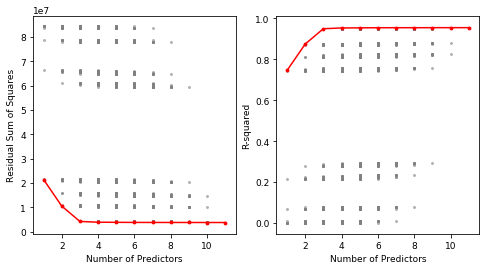

In [4]:
matplotlib.rcParams.update({'font.size': 9})
fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(Best_score.k, Best_score.RSS,color = 'grey',alpha = 0.5,s=4)
ax1.scatter(RSSmin.index, RSSmin,color = 'red',s=8)
ax1.plot(RSSmin.index, RSSmin,color = 'red')
ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Residual Sum of Squares')
ax2.scatter(Best_score.k, Best_score.R2,color = 'grey',alpha = 0.5,s=4)
ax2.scatter(R2max.index, R2max,color = 'red',s=8)
ax2.plot(R2max.index, R2max,color = 'red')
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('R-squared')
plt.show()

Now in order to select a single best model, we must simply choose among these p + 1 options. This task must be performed with care, because the RSS of these p + 1 models decreases monotonically, and the R2 increases monotonically, as the number of features included in the models increases. The problem is that a low RSS or a high R2 indicates a model with a low training error, whereas we wish to choose a model that has a low test error.   
Therefore, in Step 3, we use cross-validated prediction error,Cp, BIC, or adjusted R2 in order to select among M0,M1, . . . ,Mp. These approaches are discussed in Section 6.1.3.

### 6.1.2 Stepwise Selection
For computational reasons, best subset selection connot applied with very large $p$. And a very large search space may lead to overfitting. That's why $stepwise$ methods can be attractive.    
###### <font color="#0000dd">Algorithm 6.2 Forward Stepwise Selection</font>
Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest additional improvement to the fit is added to the model.
1. Let $M_0$ denote the $null$ $model$, which contains no predictors. This model simply predicts the sample mean for each observation.
2. For $k = 0,1,2,...p-1$:   
    (a) Fit all $p-k$ models that augment the predictors in $M_k$ with one additional predictor.   
    (b) Pick the best among these $p-k$ models ($M_{k+1}$). $Best$ is defined as having the smallest RSS or largest $R^2$.
3. Select a single best model from among $M_0,...,M_p$ using cross-validated prediction error, $C_p$(AIC), BIC, or adjusted $R^2$     
Forward stepwise selection can be applied even in the high-dimensional setting where n < p; however, in this case, it is possible to construct submodels M0, . . . ,Mn−1 only.

In [5]:
def forsubset(y,X,krange=11):
    remain = list(X.columns)
    select = []
    score = pd.DataFrame()
    for k in range(1,krange+1):
        best = []
        for j in remain:
            model = sm.OLS(list(y),sm.add_constant(X[select+[j]]).astype(float)).fit()
            best.append([k,select+[j],model.ssr,model.rsquared])
        best = pd.DataFrame(best, columns =['k','var','RSS','R2'])
        best = best.sort_values('RSS').head(1)
        score = score.append(best)
        select.append(list(best['var'])[0][-1])
        remain.remove(list(best['var'])[0][-1])
    return score

In [6]:
forward = forsubset(y,X)
print(bestvar.sort_index(ascending = True).head(5))
print(forward[forward.k <= 5]['var'])

2                                        (Rating,)
12                                (Income, Rating)
79                   (Income, Rating, Student_Yes)
242            (Income, Limit, Cards, Student_Yes)
564    (Income, Limit, Rating, Cards, Student_Yes)
Name: var, dtype: object
2                                       [Rating]
0                               [Rating, Income]
5                  [Rating, Income, Student_Yes]
0           [Rating, Income, Student_Yes, Limit]
0    [Rating, Income, Student_Yes, Limit, Cards]
Name: var, dtype: object


###### <font color="#0000dd">Algorithm 6.3 Backward Stepwise Selection</font>
Like forward stepwise selection, backward stepwise selection provides an efficient alternative to best subset selection. However, unlike forward stepwise selection, it begins with the full least squares model containing all p predictors, and then iteratively removes the least useful predictor, one-at-a-time.
1. Let $M_p$ denote the $full$ $model$, which contains all predictors. 
2. For $k = p,p-1,...,1$:   
    (a) Fit all $k$ models that contain all but one of the predictors in $M_k$ for a total of $k-1$ predictors.   
    (b) Pick the best among these $k$ models ($M_{k-1}$). $Best$ is defined as having the smallest RSS or largest $R^2$.
3. Select a single best model from among $M_0,...,M_p$ using cross-validated prediction error, $C_p$(AIC), BIC, or adjusted $R^2$

In [16]:
def backsubset(y,X,krange=11):
    remain = list(X.columns)
    score = pd.DataFrame()
    model = sm.OLS(list(y),sm.add_constant(X).astype(float)).fit()
    score = score.append(pd.DataFrame([11,list(X.columns),model.ssr,model.rsquared]).T)
    score.columns = ['k','var','RSS','R2']
    for k in range(krange-1,0,-1):
        best = []
        for j in remain:
            model = sm.OLS(list(y),sm.add_constant(X[remain].drop(j,axis=1)).astype(float)).fit()
            best.append([k,list(X[remain].drop(j,axis=1).columns),model.ssr,model.rsquared])
        best = pd.DataFrame(best, columns =['k','var','RSS','R2'])
        best = best.sort_values('RSS').head(1)
        score = score.append(best)
        remain = best.iloc[0,1]
    return score

#### Hybrid Approaches
The best subset, forward stepwise, and backward stepwise selection approaches generally give similar but not identical models. As another alternative, hybrid versions of forward and backward stepwise selection are available, in which variables are added to the model sequentially, in analogy to forward selection. However, after adding each new variable, the method may also remove any variables that no longer provide an improvement in the model fit. Such an approach attempts to more closely mimic best subset selection while retaining the computational advantages of forward and backward stepwise selection.

### 6.1.3 Choosing the Optimal Model   

In order to select the best model with respect to test error, we need to estimate this test error. There are two common approaches:      
1. We can indirectly estimate test error by making an **adjustment** to the training error to account for the bias due to overfitting.
2. We can **directly** estimate the test error, using either a validation set approach or a cross-validation approach, as discussed in Chapter 5.


#### $C_p$, AIC, BIC, and Adjusted $R^2$
In particular, the training error will decrease as more variables are included in the model, but the test error may not. Therefore, training set RSS and training set R2 cannot be used to select from among a set of models with different numbers of variables.
However, a number of techniques for adjusting the training error for the model size are available：
$$
C_p = \frac{1}{n}(RSS+2d\hat{\sigma}^2)
$$
where $\hat{\sigma}^2$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement. Though it is beyond the scope of this book, one can show that if $\hat{\sigma}^2$ is an unbiased estimate of $\sigma^2$, then $C_p$ is an unbiased estimate of test $MSE$.
$$
AIC = \frac{1}{n\hat{\sigma}^2}(RSS+2d\hat{\sigma}^2)
$$

$$
BIC = \frac{1}{n}(RSS+log(n)d\hat{\sigma}^2)
$$

$$
Adjusted R^2 = 1-\frac{RSS/(n-d-1)}{TSS/(n-1)}
$$
Despite its popularity, and even though it is quite intuitive, the adjusted $R^2$ is not as well motivated in statistical theory as $AIC$, $BIC$, and $C_p$.

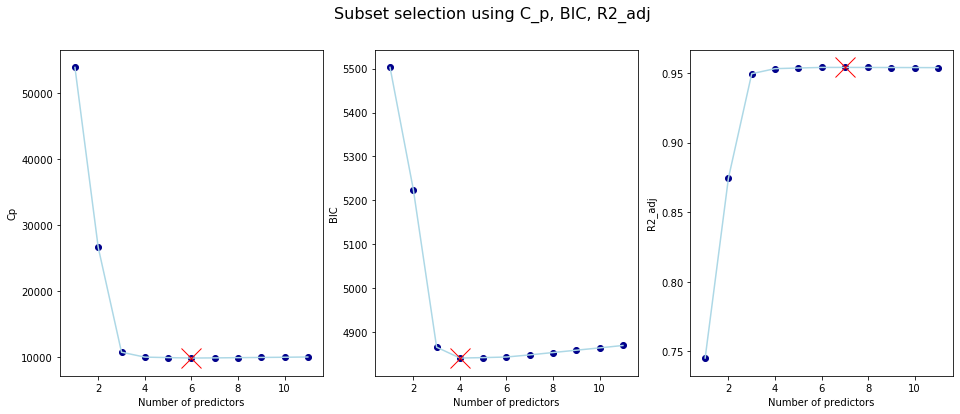

In [9]:
Best_score = Best_score.sort_values('RSS')
opt = Best_score.groupby('k').head(1)
opt = opt.set_index(['k'],drop = False)

variables = ['Cp','BIC','R2_adj']
matplotlib.rcParams.update({'font.size': 10})
fig = plt.figure(figsize = (16,6))
for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(opt['k'],opt[v], color = 'lightblue')
    ax.scatter(opt['k'],opt[v], color = 'darkblue')
    if v == 'R2_adj':
        ax.plot(opt[v].idxmax(),opt[v].max(), marker = 'x', markersize = 20,c='red')
    else:
        ax.plot(opt[v].idxmin(),opt[v].min(), marker = 'x', markersize = 20,c='red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, BIC, R2_adj', fontsize = 16)
plt.show()

#### Validation and Cross-Validation
As an alternative to the approaches just discussed, we can directly estimate the test error using the validation set and cross-validation methods discussed in Chapter 5.
More direct and more flexible.
- The validation errors were calculated by randomly selecting three-quarters of the observations as the training set, and the remainder as the validationset. 
- The cross-validation errors were computed using k = 10 folds.

D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'k' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


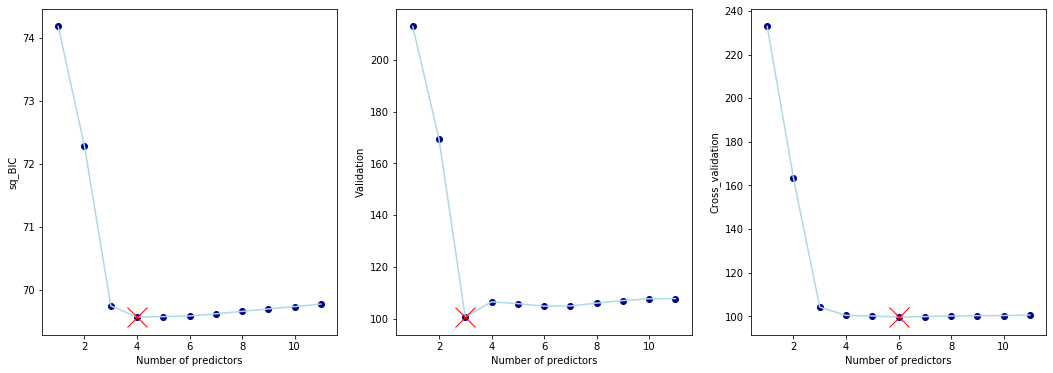

In [10]:
opt['sq_BIC'] = opt.BIC**0.5
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 123)
opt = opt.sort_values('k')
vali = []
crvali = []
lr = LinearRegression()
for i in range(1,12):
    model = sm.OLS(y_train, sm.add_constant(X_train[list(opt['var'][i])])).fit()
    y_pred = model.predict(sm.add_constant(X_test[list(opt['var'][i])]))
    crerror = ((cross_val_score(lr,X[list(opt['var'][i])],y,cv = 10,scoring = 'neg_mean_squared_error').mean())*(-1))**0.5
    vali.append((((y_pred - y_test)**2).mean())**0.5)
    crvali.append(crerror)
opt['Validation'] = vali
opt['Cross_validation'] = crvali

variables = ['sq_BIC','Validation','Cross_validation']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(opt['k'],opt[v], color = 'lightblue')
    ax.scatter(opt['k'],opt[v], color = 'darkblue')
    ax.plot(opt[v].idxmin(),opt[v].min(), marker = 'x', markersize = 20,c='red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)
plt.show()

**One-Standard-Error Rule**
If we repeated the validation set approach using a different split of the data into a training set and a validation set, or if we repeated crossvalidation using a different set of cross-validation folds, then the precise model with the lowest estimated test error would surely change. In this setting, we can select a model using the one-standard-error rule.    
We first calculate the standard error of the estimated test MSE for each model size, and then select the smallest model for which the estimated test error is within one standard error of the lowest point on the curve.

#### Lab1: Subset Selection Methods

In [11]:
Hitters = pd.read_csv('Hitters.csv')
Hitters = pd.get_dummies(Hitters, columns = ['League','Division','NewLeague'],drop_first = True)
Hitters = Hitters.dropna(axis = 0)
Hitters = Hitters.iloc[:,1:] # 去掉name

print(Hitters.columns)
np.shape(Hitters)

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')


(263, 20)

In [ ]:
Best_score2 = BestSubset(Hitters.Salary,Hitters.drop('Salary',axis=1),krange=19) # 非常耗时
Best_score2 = pd.DataFrame(Best_score2, columns= ['k','var','RSS','R2','R2_adj','AIC','BIC'])
Best_score2['Cp'] = (Best_score2.RSS + 2*Best_score2.k*(Best_score2.RSS/(n-1-Best_score2.k)))/n
Best_score2 = Best_score2.sort_values('RSS')
bestMk = Best_score2.groupby('k').head(1)
bestMk = bestMk.set_index(['k'],drop = False)

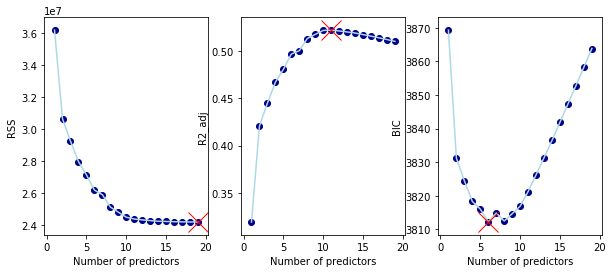

In [3]:
bestMk = pd.read_csv('bestMk.csv',index_col=0)
bestMk.columns = ['k','var','RSS','R2','R2_adj','AIC','BIC','Cp']

#RSSmin2 = Best_score2.groupby('k').RSS.min()
#R2max2 = Best_score2.groupby('k').R2.max()
#bestvar2 = Best_score2.groupby('k').head(1)['var']
variables = ['RSS','R2_adj','BIC']
matplotlib.rcParams.update({'font.size': 10})

fig = plt.figure(figsize = (10,4))
for i,v in enumerate(variables):
    ax = fig.add_subplot(1,3, i+1)
    ax.plot(bestMk['k'],bestMk[v], color = 'lightblue')
    ax.scatter(bestMk['k'],bestMk[v], color = 'darkblue')
    if v == 'R2_adj':
        ax.plot(bestMk[v].idxmax(),bestMk[v].max(), marker = 'x', markersize = 20,c='red')
    else:
        ax.plot(bestMk[v].idxmin(),bestMk[v].min(), marker = 'x', markersize = 20,c='red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)
plt.show()

In [18]:
forward2 = forsubset(Hitters.Salary,Hitters.drop('Salary',axis=1),krange=19)
backward2 = backsubset(Hitters.Salary,Hitters.drop('Salary',axis=1),krange=19)

print(list(bestMk[bestMk.k == 7]['var']))
print(list(forward2[forward2.k == 7]['var']))
print(list(backward2[backward2.k == 7]['var']))

["('Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W')"]
[['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']]
[['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts', 'Division_W']]


## 6.2 Shrinkage Methods
As an alternative, we can fit a model containing all p predictors using a technique that constrains or regularizes the coefficient estimates, or equivalently, that shrinks the coefficient estimates towards zero.The two best-known techniques for shrinking the regression coefficients towards zero are $ridge$ $regression$ and the $lasso$.

### 6.2.1 Ridge Regression
$$
RSS = \sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx^{ij})^2
$$
Ridge regression is very similar to least squares, except that the coefficients ridge regression are estimated by minimizing a slightly different quantity.In particular, the ridge regression coefficient estimates $\hat{\beta}^R$ are the values that minimize
$$
\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda\sum_{j=1}^{p}\beta_j^2 = RSS + \lambda\sum_{j=1}^{p}\beta_j^2
$$
where $\lambda ≥ 0$ is a tuning parameter, to be determined separately.$\lambda\sum_{j=1}^{p}\beta_j^2$ is called $shrinkage$ $penalty$. 
When $\lambda = 0$, the penalty term has no effect, and ridge regression will produce the least squares estimates. However, as $\lambda \rightarrow ∞$, the impact of the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero.Selecting a good value for $\lambda$ is critical; we defer this discussion to Section 6.2.3, where we use cross-validation.   
Note that the shrinkage penalty is applied to $\beta_1, . . . , \beta_p$, but not to the intercept $\beta_0$.

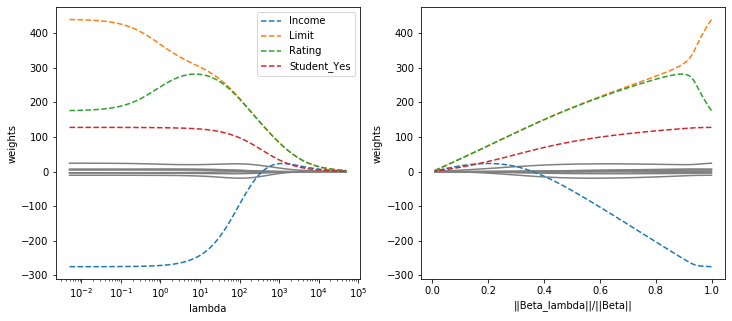

In [19]:
alphas = 10**np.linspace(-2,5,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = pd.DataFrame(coefs, columns = X.columns)

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
the4var = ['Income','Limit','Rating','Student_Yes']
ax1.plot(alphas, coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax1.plot(alphas, coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('weights')
ax1.legend()

a = 0
ridge.set_params(alpha=a)
ridge.fit(scale(X), y)
B2 = (ridge.coef_**2).sum()
coefs['BR2'] = np.sqrt(((coefs**2).T).sum()/B2)

ax2.plot(coefs['BR2'], coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax2.plot(coefs['BR2'], coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax2.set_xlabel('||Beta_lambda||/||Beta||')
ax2.set_ylabel('weights')
plt.show()

##### Why Does Ridge Regression Improve Over Least Squares?
Ridge regression’s advantage over least squares is rooted in the bias-variance trade-off. As $\lambda$ increases, the shrinkage of the ridge coefficient estimates leads to a substantial reduction in the variance of the predictions, at the expense of a slight increase in bias.
**This trade off relation was displayed in Chapter 5.**

### 6.2.2 The Lasso
Unlike best subset, forward stepwise, and backward stepwise selection, which will generally select models that involve just a subset of the variables, ridge regression will include all $p$ predictors in the final model.This may not be a problem for prediction accuracy, but it can create a challenge in model interpretation in settings in which the number of variables $p$ is quite large.The lasso is a relatively recent alternative to ridge regression that overcomes this disadvantage.The lasso coefficients minimize the quantity:
$$
\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda\sum_{j=1}^{p}|\beta_j| = RSS + \lambda\sum_{j=1}^{p}|\beta_j|
$$
In statistical parlance, the lasso uses an $l1$ penalty instead of an $l2$ penalty.In the case of the lasso, the $l1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large.

D:\Users\longzhen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
D:\Users\longzhen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Users\longzhen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0, 0.5, 'weights')

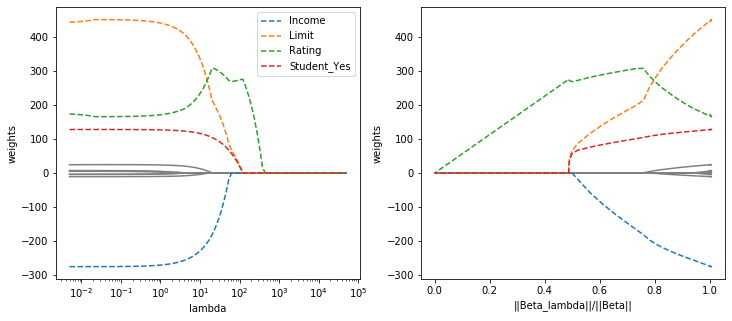

In [20]:
# Lasso
ridge = Lasso()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = pd.DataFrame(coefs, columns = X.columns)

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
the4var = ['Income','Limit','Rating','Student_Yes']
ax1.plot(alphas, coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax1.plot(alphas, coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('weights')
ax1.legend()

a = 0
ridge.set_params(alpha=a)
ridge.fit(scale(X), y)
B2 = (ridge.coef_**2).sum()
coefs['BR2'] = np.sqrt(((coefs**2).T).sum()/B2)

ax2.plot(coefs['BR2'], coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax2.plot(coefs['BR2'], coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax2.set_xlabel('||Beta_lambda||/||Beta||')
ax2.set_ylabel('weights')

##### Another formula for Ridge Regression and Lasso
$$
minimize\left\{\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2\right\} s.t. \sum_{j=1}^{p}|\beta_j|\leqslant s
$$


$$
minimize\left\{\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2\right\} s.t. \sum_{j=1}^{p}\beta_j^2\leqslant s
$$

In other words, for every value of $λ$, there is some $s$ that will give the same lasso coefficient estimates.Similarly, for every value of $λ$ there is a corresponding $s$ such that will give the same ridge regression coefficient estimates. When $p = 2$, then it indicates that the lasso coefficient estimates have the smallest RSS out of all points that lie within the diamond defined by $|β_1| + |β_2| ≤ s$. Similarly, the ridge regression estimates have the smallestRSS out of all points that lie within the circle defined by $β_1^2 + β_2^2 ≤ s$.   
Consider 
$$
minimize\left\{\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2\right\} s.t. \sum_{j=1}^{p}I(\beta_j≠0)\leqslant s
$$
The problem amounts to finding a set of coefficient estimates such that RSS is as small as possible, subject to the constraint that no more than s coefficients can be nonzero. The problem is equivalent to best subset selection.Unfortunately, this is computationally infeasible when p is large, since it requires considering
all $C_p^k$ models containing s predictors. Therefore, we can interpret ridge regression and the lasso as computationally feasible alternatives to best subset selection that replace the intractable form of the budget with forms that are much easier to solve. Of course, the lasso is much more closely related to best subset selection, since only the lasso performs feature selection for s sufficiently small.

###### Comparing the Lasso and Ridge Regression
Lasso selects variables while Ridge Regressions only shrink the parameters. It is clear that the lasso has a major advantage over ridge regression, in that it produces simpler and more interpretable models that involve only a subset of the predictors.

###### A Simple Special Case for Ridge Regression and the Lasso
In order to obtain a better intuition about the behavior of ridge regression and the lasso, consider a simple special case with n = p, and X a diagonal matrix with 1’s on the diagonal and 0’s in all off-diagonal elements. To simplify the problem further, assume also that we are performing regression without an intercept.
We can calculate the results that the Ridge Regression estimates take the form:
$$
\hat{\beta}_j^R = y_j/(1+\lambda)
$$
And the Lasso estimates take the form:
$$
\hat{\beta}_j^L=\left\{
\begin{array}{rcl}
y_j-\lambda/2       &      & {y_j      >      \lambda/2}\\
y_j+\lambda/2     &      & {y_j      <      -\lambda/2}\\
0   &      & {otherwise}
\end{array} \right.
$$
We can see that ridge regression and the lasso perform two very different types of shrinkage. In ridge regression, each least squares coefficient estimate is shrunken by the same proportion.In contrast, the lasso shrinks each least squares coefficient towards zero by a constant amount, λ/2; the least squares coefficients that are less than λ/2 in absolute value are shrunken entirely to zero.The type of shrinkage performed by the lasso in this simple setting is known as $soft-thresholding$. The fact that some lasso coefficients are shrunken entirely to soft-thresholding zero explains why the lasso performs feature selection.

### 6.2.3 Selecting the Tuning Parameter

Cross-validation provides a simple way to tackle this problem. We choose a grid of λ values, and compute
the cross-validation error for each value of λ, as described in Chapter 5. We then select the tuning parameter value for which the cross-validation error is smallest. Finally, the model is re-fit using all of the available observations and the selected value of the tuning parameter.

### Lab 2: Ridge Regression and the Lasso

In [3]:
Hitters = pd.read_csv('Hitters.csv')
Hitters = pd.get_dummies(Hitters, columns = ['League','Division','NewLeague'],drop_first = True)
Hitters = Hitters.dropna(axis = 0)
Hitters = Hitters.iloc[:,1:] # 去掉name
y = Hitters.Salary
X = Hitters.drop('Salary',axis=1)

X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

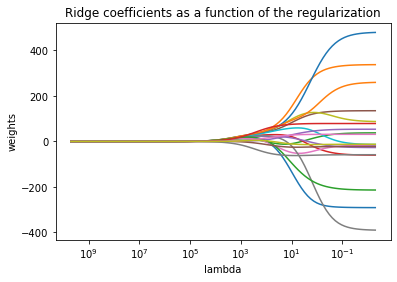

In [4]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridge = Ridge()
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
ridge2 = Ridge(alpha=705)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
print(mean_squared_error(y_test, pred))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

118482.9670665639


AtBat          12.870669
Hits           15.188099
HmRun          12.411658
Runs           14.878940
RBI            15.346209
Walks          22.975651
Years           6.130568
CAtBat         14.090004
CHits          15.932278
CHmRun         12.315527
CRuns          17.630390
CRBI           14.205774
CWalks         15.290584
PutOuts         5.870662
Assists       -13.413488
Errors         19.460360
League_N        3.187834
Division_W      2.501010
NewLeague_N     5.305309
dtype: float64

In [7]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
print(mean_squared_error(y_test, pred))

193253.09741651407


In [8]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)
ridgecv.alpha_

115.50648500415791

In [9]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

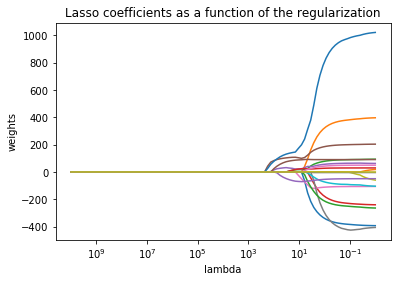

In [10]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');
plt.show()

In [11]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())
lassocv.alpha_

30.01382256446427

In [12]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

## 6.3 Dimension Reduction Methods

   The methods that we have discussed so far in this chapter have controlled variance in two different ways, either by using a subset of the original variables, or by shrinking their coefficients toward zero. All of these methods are defined using the original predictors, $X_1$, $X_2$, ..., $X_p$. We now explore a class of approaches that transform the predictors and then fit a least squares model using the transformed variables. We will refer to these techniques as dimension reduction methods.
   
   Dimension reduction methods transform the predictors and then fit a least squares model using the transformed variables. Let $Z_1$, $Z_2$, ..., $Z_M$ represent $M<p$ $linear$ $combinations$ of our original $p$ predictors. That is, 
$$Z_m=\sum \limits_{j=1}^p \phi_{jm}X_{j}  \qquad  (6.16) $$
for some constants $\phi_{1m}$, $\phi_{2m}$..., $\phi_{pm}$, $m=1$,..., $M$. We can then fit the linear regression model
$$y_{i}=\theta_0+\sum \limits_{m=1}^M \theta_{m}z_{im}+\epsilon_{i}, \quad  i=1,...,n   \qquad  (6.17) $$
using least squares.

The term dimension reduction comes from the fact that this approach reduces the problem of estimating the $p+1$ coefficients $\beta_0$, $\beta_1$,..., $\beta_p$ to the simpler problem of estimating the $M + 1$ coefficients $\theta_0$, $\theta_1$, ..., $\theta_{M}$, where $M < p$. In other words, the dimension of the problem has been reduced from $p+1$ to $M+1$.

Notice that from (6.16),
$$ \sum \limits_{m=1}^M \theta_{m}z_{im}=\sum \limits_{m=1}^M \sum \limits_{j=1}^p \theta_{jm} x_{ij} = \sum \limits_{j=1}^p \sum \limits_{m=1}^M \theta_{m} \phi_{jm} x_{ij} = \sum \limits_{j=1}^p \beta_{j} x_{ij}$$
where
$$\beta_{j}=\sum \limits_{m=1}^M \theta_{m} \phi_{jm}   \qquad  (6.18) $$

Hence (6.17) can be thought of as a special case of the original linear regression model given by (6.1). Dimension reduction serves to constrain the estimated $\beta_{j}$ coefficients, since now they must take the form (6.18). This constraint on the form of the coefficients has the potential to bias the coefficient estimates. However, in situations where $p$ is large relative to n, selecting a value of $M \ll p$ can significantly reduce the variance of the fitted coefficients. If $M = p$, and all the $Z_m$ are linearly independent, then (6.18) poses no constraints. In this case, no dimension reduction occurs, and so fitting (6.17) is equivalent to performing least squares on the original $p$ predictors.

### 6.3.1 Principal Components Regression
Principal components analysis (PCA) is a popular approach for deriving a low-dimensional set of features from a large set of variables. PCA is discussed in greater detail as a tool for unsupervised learning in Chapter 10. Here we describe its use as a dimension reduction technique for regression.

#### An Overview of Principal Components Analysis
PCA is a technique for reducing the dimension of a $n × p$ data matrix $X$. The first principal component direction of the data is that along which the observations vary the most. For instance, consider Figure 6.14, which shows population size ($pop$) in tens of thousands of people, and ad spending for a particular company ($ad$) in thousands of dollars, for 100 cities. The green solid line represents the first principal component direction of the data. We can see by eye that this is the direction along which there is the greatest variability in the data. That is, if we $projected$ the 100 observations onto this line, then the resulting projected observations would have the largest possible variance; projecting the observations onto any other line would yield projected observations with lower variance. Projecting a point onto a line simply involves finding the location on the line which is closest to the point.

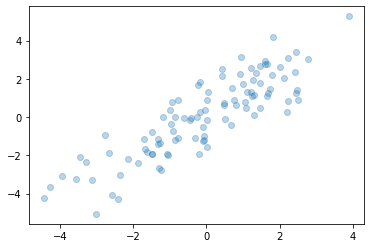

In [1]:
# Figure 6.14
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

rng = np.random.RandomState(0)
n_samples = 100
cov = [[3, 3],
       [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')

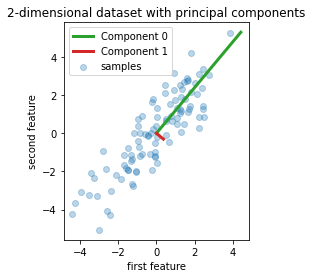

In [2]:
plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=3,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

The first principal component is displayed graphically in Figure 6.14, but how can it be summarized mathematically? $$Z_1=0.839\times(pop-\overline{pop})+0.544\times(ad-\overline{ad})$$

$\overline{pop}$ indicates the mean of all pop values in this data set, and  $\overline{ad}$ indicates the mean of all advertising spending. The idea is that out of every possible linear combination of pop and ad such that $\phi_{11}^2 + \phi_{21}^2 = 1$, this particular linear combination yields the highest variance: i.e. this is the linear combination for which $Var(\phi_{11} \times (pop − \overline{pop}) + \phi_{21} \times (ad − \overline{ad}))$ is maximized. It is necessary to consider only linear combinations of the form $\phi_{11}^2+\phi_{21}^2=1$, since otherwise we could increase $\phi_{11}$ and $\phi_{21}$ arbitrarily in order to blow up the variance. 

There is also another interpretation for PCA: the first principal component vector defines the line that is as close as possible to the data. For instance, in Figure 6.14, the first principal component line minimizes the sum of the squared perpendicular distances between each point and the line. Figure 6.16 displays $z_{i1}$ versus both $pop$ and $ad$. The plots show a strong relationship between the first principal component and the two features. In other words, the first principal component appears to capture most of the information contained in the $pop$ and $ad$ predictors.

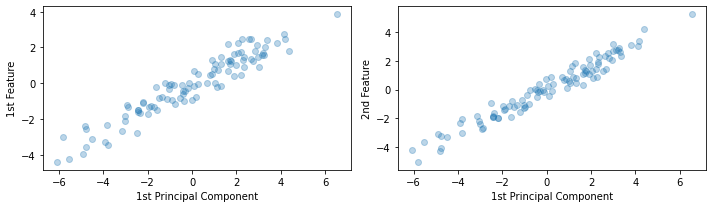

In [3]:
# Figure 6.16 
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[0]), X[:, 0], alpha=.3)
axes[0].set(xlabel='1st Principal Component', ylabel='1st Feature')
axes[1].scatter(X.dot(pca.components_[0]), X[:, 1], alpha=.3)
axes[1].set(xlabel='1st Principal Component', ylabel='2nd Feature')
plt.tight_layout()
plt.show()

So far we have concentrated on the first principal component. In general, one can construct up to p distinct principal components. The second principal component $Z_2$ is a linear combination of the variables that is uncorrelated with $Z_1$, and has largest variance subject to this constraint. It turns out that the zero correlation condition of $Z_1$ with $Z_2$ is equivalent to the condition that the direction must be perpendicular, or orthogonal, to the first principal component direction. The second principal component is given by the formula
$$Z_2=0.544\times(pop-\overline{pop})-0.839\times(ad-\overline{ad})$$
Since the advertising data has two predictors, the first two principal components contain all of the information that is in $pop$ and $ad$. However, by construction, the first component will contain the most information.

The fact that the second principal component scores are much closer to zero indicates that this component captures far less information. As another illustration, Figure 6.17 displays $z_{i2}$ versus $pop$ and $ad$. There is little relationship between the second principal component and these two predictors, again suggesting that in this case, one only needs the first principal component in order to accurately represent the pop and ad budgets.

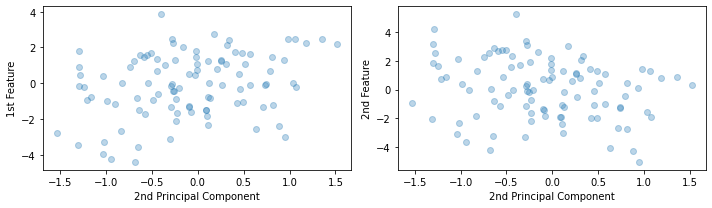

In [4]:
# Figure 6.17
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[1]), X[:, 0], alpha=.3)
axes[0].set(xlabel='2nd Principal Component', ylabel='1st Feature')
axes[1].scatter(X.dot(pca.components_[1]), X[:, 1], alpha=.3)
axes[1].set(xlabel='2nd Principal Component', ylabel='2nd Feature')
plt.tight_layout()
plt.show()

#### The Principal Components Regression Approach
The principal components regression (PCR) approach involves constructing the first M principal components, $Z_1$, ..., $Z_M$, and then using these components as the predictors in a linear regression model that is fit using least squares. The key idea is that often a small number of principal components suffice to explain most of the variability in the data, as well as the relationship with the response. In other words, we assume that the directions in which $X_1$, ..., $X_p$ show the most variation are the directions that are associated with $Y$.

The relatively worse performance of PCR in Figure 6.18 is a consequence of the fact that the data were generated in such a way that many principal components are required in order to adequately model the response. In contrast, PCR will tend to do well in cases when the first few principal components are sufficient to capture most of the variation in the predictors as well as the relationship with the response. The left-hand panel of Figure 6.19 illustrates the results from another simulated data set designed to be more favorable to PCR. Here the response was generated in such a way that it depends exclusively on the first five principal components. Now the bias drops to zero rapidly as M, the number of principal components used in PCR, increases. The mean squared error displays a clear minimum at M = 5. The right-hand panel of Figure 6.19 displays the results on these data using ridge regression and the lasso. All three methods offer a significant improvement over least squares. However, PCR and ridge regression slightly outperform the lasso.

In PCR, the number of principal components, $M$, is typically chosen by cross-validation.

![Fig6.18](fig/fig6.18.png)

## 6.3.2 Partial Least Squares
The PCR approach that we just described involves identifying linear combinations, or directions, that best represent the predictors $X_1$, ..., $X_p$. These directions are identified in an unsupervised way, since the response $Y$ is not used to help determine the principal component directions. That is, the response does not supervise the identification of the principal components. Consequently, PCR suffers from a drawback: there is no guarantee that the directions that best explain the predictors will also be the best directions to use for predicting the response. 

We now present $partial$ $least$ $squares$ (PLS), a supervised alternative to PCR. Like PCR, PLS is a dimension reduction method, which first identifies a new set of features $Z_1$, ..., $Z_M$ that are linear combinations of the original features, and then fits a linear model via least squares using these $M$ new features. But unlike PCR, PLS identifies these new features in a supervised way — that is, it makes use of the response $Y$ in order to identify new features that not only approximate the old features well, but also that are related to the response. Roughly speaking, the PLS approach attempts to find directions that help explain both the response and the predictors.

We now describe how the first PLS direction is computed. After standardizing the $p$ predictors, PLS computes the first direction $Z_1$ by setting each $\phi_{j1}$ in (6.16) equal to the coefficient from the simple linear regression of $Y$ onto $X_j$. One can show that this coefficient is proportional to the correlation between $Y$ and $X_j$. Hence, in computing $Z_1=\sum \limits_{j=1}^p \phi_{ji}X_j$, PLS places the highest weight on the variables that are most strongly related to the response.

To identify the second PLS direction we first adjust each of the variables for $Z_1$, by regressing each variable on $Z_1$ and taking residuals. These residuals can be interpreted as the remaining information that has not been explained by the first PLS direction. We then compute $Z_2$ using this orthogonalized data in exactly the same fashion as $Z_1$ was computed based on the original data. This iterative approach can be repeated $M$ times to identify multiple PLS components $Z_1$, ..., $Z_M$. Finally, at the end of this procedure, we use least squares to fit a linear model to predict $Y$ using $Z_1$, ..., $Z_M$ inexactly the same fashion as for PCR.

As with PCR, the number $M$ of partial least squares directions used in PLS is a tuning parameter that is typically chosen by cross-validation. We generally standardize the predictors and response before performing PLS.

## 6.4 Considerations in High Dimensions
### 6.4.1 High-Dimensional Data
Most traditional statistical techniques for regression and classification are intended for the $low$-$dimensional$ setting in which $n$, the number of observations, is much greater than $p$, the number of features.

In the past twenty years, new technologies have changed the way that data are collected in fields as diverse as finance, marketing, and medicine. It is now commonplace to collect an almost unlimited number of feature measurements ($p$ very large). While p can be extremely large, the number of observations $n$ is often limited due to cost, sample availability, or other considerations.

Data sets containing more features than observations are often referred to as high-dimensional. Classical approaches such as least squares linear regression are not appropriate in this setting. Many of the issues that arise in the analysis of high-dimensional data were discussed earlier in this book, since they apply also when $n > p$: these include the role of the bias-variance trade-off and the danger of overfitting. Though these issues are always relevant, they can become particularly important when the number of features is very large relative to the number of observations. We have defined the high-dimensional setting as the case where the number of features $p$ is larger than the number of observations $n$. But the considerations that we will now discuss certainly also apply if $p$ is slightly smaller than $n$, and are best always kept in mind when performing supervised learning.

### 6.4.2 What Goes Wrong in High Dimensions?
When the number of features $p$ is as large as, or larger than, the number of observations $n$, least squares as described in Chapter 3 cannot (or rather, should not) be performed. The reason is simple: regardless of whether or not there truly is a relationship between the features and the response, least squares will yield a set of coefficient estimates that result in a perfect fit to the data, such that the residuals are zero.

When there are 20 observations, $n > p$ and the least squares regression line does not perfectly fit the data; instead, the regression line seeks to approximate the 20 observations as well as possible. On the other hand, when there are only two observations, then regardless of the values of those observations, the regression line will fit the data exactly. This is problematic because this perfect fit will almost certainly lead to overfitting of the data. In other words, though it is possible to perfectly fit the training data in the high-dimensional setting, the resulting linear model will perform extremely poorly on an independent test set, and therefore does not constitute a useful model. In fact, we can see that this happened in Figure 6.22: the least squares line obtained in the right-hand panel will perform very poorly on a test set comprised of the observations in the left-hand panel. The problem is simple: when $p>n$ or $p\approx n$, a simple least squares regression line is too $flexible$ and hence overfits the data.

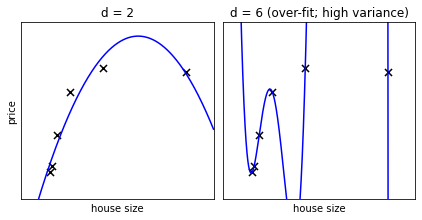

In [10]:
# Figure 6.22
import numpy as np
import matplotlib.pyplot as plt

def generating_func(x, err=0.5):
    return np.random.normal(10 - 1. / (x + 0.1), err)

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

n_samples = 6

np.random.seed(0)
x = 10 ** np.linspace(-2, 0, n_samples)
y = generating_func(x)

x_test = np.linspace(-0.2, 1.2, 1000)

titles = ['d = 2',
          'd = 6 (over-fit; high variance)']
degrees = [2, 6]

fig = plt.figure(figsize=(9, 3.5))
fig.subplots_adjust(left=0.06, right=0.98, bottom=0.15, top=0.85, wspace=0.05)

for i, d in enumerate(degrees):
    ax = fig.add_subplot(131 + i, xticks=[], yticks=[])
    ax.scatter(x, y, marker='x', c='k', s=50)

    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(x[:, np.newaxis], y)
    ax.plot(x_test, model.predict(x_test[:, np.newaxis]), '-b')

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(0, 12)
    ax.set_xlabel('house size')
    if i == 0:
        ax.set_ylabel('price')

    ax.set_title(titles[i])

## 6.7 Lab 3: PCR and PLS Regression
### 6.7.1 Principal Components Regression
We now apply PCR to the Hitters data, in order to predict salary.

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

df = pd.read_csv('Hitters.csv').dropna().drop('Player', axis=1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [12]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

pca = PCA()
X_reduced = pca.fit_transform(scale(X))

pd.DataFrame(pca.components_.T).loc[:4,:19]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646,0.107044,0.269810,-0.012183,0.145621,0.097328,0.103150,-0.039850,0.306248,0.532433,-0.510331,0.139342,-0.106790,0.053777
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240,0.130026,0.388722,-0.061604,0.130476,0.014433,0.121009,0.003593,0.210616,-0.023442,0.720168,-0.167363,0.043568,-0.097782
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646,-0.505833,-0.226278,0.127422,-0.351111,-0.202190,-0.314852,-0.108689,-0.001353,0.355455,0.200408,0.047702,-0.058377,-0.024805
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660,0.201764,0.114518,-0.171230,0.032245,-0.312187,-0.321700,-0.381219,-0.266583,-0.468300,-0.220518,0.140946,0.047050,0.059145
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675,-0.319440,0.005082,0.131146,-0.172233,0.243415,0.347752,0.440143,-0.007486,-0.461468,-0.237366,-0.106688,0.063998,0.019351


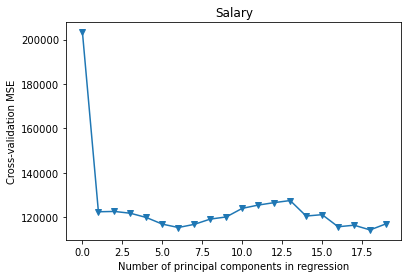

In [13]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Cross-validation MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [14]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

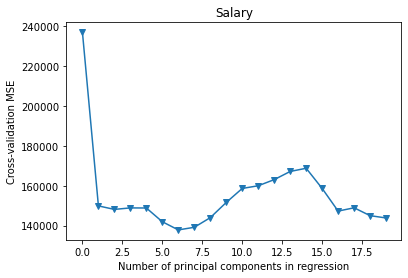

In [23]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Cross-validation MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [22]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(pred, y_test)

99427.91767492905

### 6.7.2 Partial Least Squares
We implement partial least squares (PLS) to the Hitters data. 

(-1.0, 19.9)

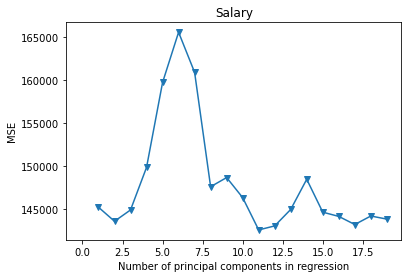

In [17]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

In [18]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104838.51042760802